<p> <img src="https://cat.opidor.fr/images/2/2c/LOGOTETIS.png" width="25%";"/></p>

## **Sentiment Analysis of Movie Review: QA Evaluation**


**Mehtab Alam Syed, Munib Hassan**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # library for ploting data
import seaborn as sns # library for visualization
from bs4 import BeautifulSoup
import re
import nltk
import spacy
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_val_predict

## Reading Movie review CSV Dataset

In [ ]:
#https://drive.google.com/file/d/1yoWINAEmm0keMJ1ZnrTgfBZAy2suE4ji/view?usp=sharing
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1yoWINAEmm0keMJ1ZnrTgfBZAy2suE4ji') # read our dataset
print(df.shape)
df.head(5)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Choosing first 5000 reviews as example for this work

In [ ]:
df = df.head(5000)
print(df.shape)
df["sentiment_int"] = df["sentiment"].map({"positive": 1, "negative": 0})
df.head(5)

(5000, 2)


,review,sentiment,sentiment_int
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
df.sentiment_int.value_counts()

0    2532
1    2468
Name: sentiment_int, dtype: int64

<ipython-input-5-ef795b2f05ff>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= df['sentiment'],ax=ax, palette=['#00A36C', "#DE3163"]).set_title('Dataset Example details') # Bar chart using seaborn chart to see the classes


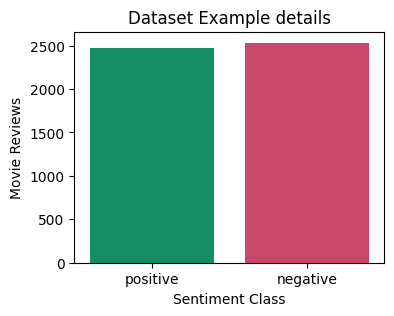

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x= df['sentiment'],ax=ax, palette=['#00A36C', "#DE3163"]).set_title('Dataset Example details') # Bar chart using seaborn chart to see the classes
plt.xlabel('Sentiment Class') # Binary classes (positive, negetive)
plt.ylabel('Movie Reviews') # Total news for each class
plt.show()

<a name="preprocessor"></a>
# Preprocessor

As mentioned in the introduction, this step mainly consists in retrieving the content of news articles by removing irrelevant elements (pictures, ads, hyperlinks, etc.). This is what we do in the section [*Text Cleaning*](#preprocessor_textcleaning).

<a name="preprocessor_textcleaning"></a>
# Text Cleaning

**We perform the following tasks:**
* Removing accented chars
* Removing special characters
* Removing HTML tags
* Lemmatization
* Removing stopwords (from NLTK)
* Removing extra lines
* Lowercasing
* Removing extra newlines
* Removing special characters and\or digits    
* Inserting spaces between special characters to isolate them    
* Removing extra whitespace

In [ ]:
nlp = spacy.load('en_core_web_sm') # en_core_web_sm, en_core_web_md, en_core_web_lg, en_core_web_trf

nltk.download('stopwords') # a, the , in , of , ...
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def lemmatize_text(text): # works, working -> work
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# normalize each document in the corpus
def preprocess_text(doc):
    # strip HTML
    doc = strip_html_tags(doc)
    # remove accented characters
    doc = remove_accented_chars(doc)
    # lowercase the text
    doc = doc.lower()
    # remove extra newlines
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    # lemmatize text
    doc = lemmatize_text(doc)
    # remove special characters and\or digits
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([{.(-)!}])')
    doc = special_char_pattern.sub(" \\1 ", doc)
    doc = remove_special_characters(doc, remove_digits=True)
    # remove extra whitespace
    doc = re.sub(' +', ' ', doc)
    # remove stopwords
    doc = remove_stopwords(doc, is_lower_case=True)
    return doc

In [ ]:
df['preprocessed_review'] = df['review'].apply(preprocess_text)

<ipython-input-7-d56507c7b3f0>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
df.head(5)

,review,sentiment,sentiment_int,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,1,one reviewer mention watch oz episode hook rig...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,1,I think wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love time money visually stunnin...


## Traing -  Test split (80%-20%)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

train_x, train_y = train['preprocessed_review'], train['sentiment']
test_x, test_y = test['preprocessed_review'], test['sentiment']

## Vectorizer (BOW) with N-gram (N=1)

In [ ]:
countVectorizer = CountVectorizer(stop_words='english')
train_x_vector = countVectorizer.fit_transform(train_x)

pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=train_x.index,
                                  columns=countVectorizer.get_feature_names_out())

,__________________________________________________________________footnote,aaa,aaargh,aaaugh,aag,aaliyah,aame,aamir,aardman,aaron,...,zucker,zudina,zue,zulu,zuniga,zurich,zuwarrior,zwart,zzzzip,zzzzzzzzzzzzzzzzzz
4227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Transform the test data into vectors

In [ ]:
test_x_vector = countVectorizer.transform(test_x)
pd.DataFrame.sparse.from_spmatrix(test_x_vector,
                                  index=test_x.index,
                                  columns=countVectorizer.get_feature_names_out())

,__________________________________________________________________footnote,aaa,aaargh,aaaugh,aag,aaliyah,aame,aamir,aardman,aaron,...,zucker,zudina,zue,zulu,zuniga,zurich,zuwarrior,zwart,zzzzip,zzzzzzzzzzzzzzzzzz
1501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Training logostic regression model

## Different Evaluation Matrices

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
lr = LogisticRegression()
lr.fit(train_x_vector,train_y) # training a model


y_pred = lr.predict(countVectorizer.transform(test_x))

print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(lr.score(train_x_vector, train_y)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(countVectorizer.transform(test_x), test_y)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(precision_score(test_y.to_numpy(), y_pred, pos_label="positive")))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of logistic regression classifier on train set: 1.00
Accuracy of logistic regression classifier on test set: 0.84
Precision of logistic regression classifier on test set: 0.82


- **Evaluation Matrix:** Classification Report

<p> <img src="https://i.stack.imgur.com/U0hjG.png" width="25%";"/></p>



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y,
                            lr.predict(test_x_vector),
                            labels=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.82      0.85      0.84       470
    negative       0.86      0.84      0.85       530

    accuracy                           0.84      1000
   macro avg       0.84      0.85      0.84      1000
weighted avg       0.85      0.84      0.85      1000



**Confusion Matrix**

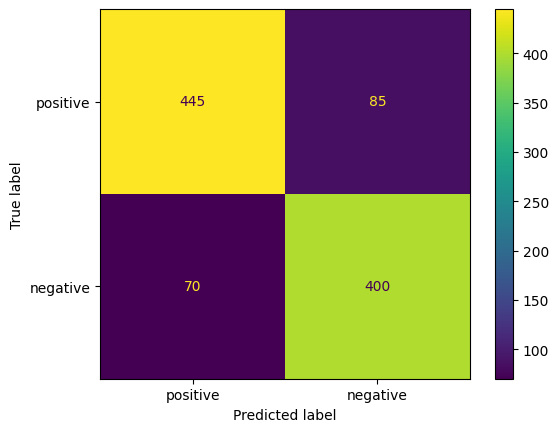

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_y,
                            y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative']).plot()

## ROC/AUC curve Evaluation

AUC for our classifier is: 0.9128141308711362


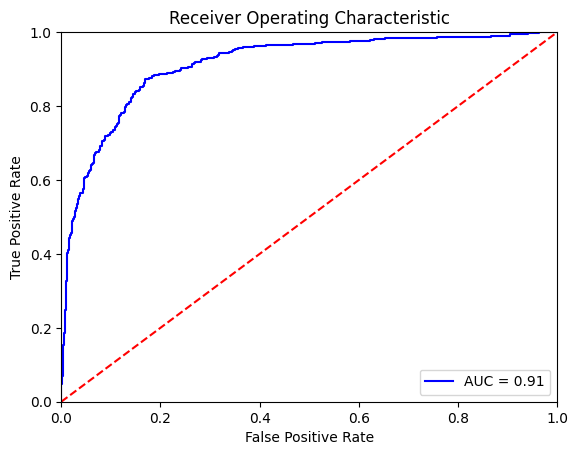

In [ ]:
from sklearn.metrics import roc_curve, auc

class_probabilities = lr.predict_proba(countVectorizer.transform(test_x))
preds = class_probabilities[:, 1]

test_y = test_y.map({'positive': 1, 'negative': 0}).astype(int) #(Comment in case it is already an error or already int)

fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Some running examples

In [ ]:
examples = ['A bad movie','I hate this movie at all', 'I like this movie at all']

print(lr.predict(countVectorizer.transform(examples)))


['negative' 'negative' 'positive']


In [ ]:

examples_from_audience = ['The movie was bad but I like the stars of the movie','The story was awesome but pathetic performance of stars']
print(lr.predict(countVectorizer.transform(examples_from_audience)))

['negative' 'positive']
